<a href="https://colab.research.google.com/github/Kamruzzaman2200/Ai/blob/main/k_fold_improve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install libraries

In [1]:
!pip install imblearn boruta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 1.9 MB/s eta 0:00:00


# Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data & preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

# Sampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Feature engineering
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import RFE
from boruta import BorutaPy

# Estimators for RFE/Boruta
from sklearn.ensemble import RandomForestClassifier

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import make_scorer, accuracy_score

#Load data & Inspect

In [3]:
# Path to the uploaded file
file_path = "/content/drive/MyDrive/DataSets/1-s2.0-S2352340921006314-mmc2.csv"

df = pd.read_csv(file_path)
print("✅ Dataset loaded:", file_path)

print("\n--- Shape ---")
print(df.shape)

print("\n--- Columns ---")
print(df.columns.tolist())

print("\n--- First 5 rows ---")
print(df.head())

print("\n--- Info ---")
df.info()

✅ Dataset loaded: /content/drive/MyDrive/DataSets/1-s2.0-S2352340921006314-mmc2.csv

--- Shape ---
(672, 54)

--- Columns ---
['1. Express your consent to participate in the research and processing of anonymous data for scientific purposes.', '2. Age range in years', '3. Sex', '4. Weight and height ratio/BMI score', '5. Marital status', '6. Education level', '7. Occupation', '8. Economic status', '9. Residence area', '10. Living status', '11. Smoking habit', '1. In the past 30 days, I lack companionship.', '2. In the past 30 days, there is no one I can turn to.', '3. In the past 30 days, I feel left out.', '4. In the last 30 days, I feel isolated from others.', '5. In the last 30 days, I am unhappy being so withdrawn.', '6. In the last 30 days, people are around me but not with me.', '7. In the last 30 days, I am an outgoing person.', '8. In the last 30 days, I can find companionship when I want it.', '1. In the last two weeks, little interest or pleasure in doing things.', '2. In the 

In [4]:
df.shape

(672, 54)

#Clean & encode

In [5]:
# Define the target column
target = '19. during the past month, how would you rate your sleep quality overall?'

# Normalize all column names to be safe
df.columns = df.columns.str.strip().str.lower()
# Clean the target variable name as well
target = target.strip().lower()

# Encode the target column from categorical strings to numbers
# This is essential for the model to understand it.
if target in df.columns:
    df[target] = LabelEncoder().fit_transform(df[target].astype(str))
    print(f"✅ Target column '{target}' encoded.")
else:
    print(f"❌ ERROR: Target column '{target}' not found in the dataset!")

# Convert other potential object columns to numeric where possible
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            # Attempt to encode the column using LabelEncoder
            df[col] = LabelEncoder().fit_transform(df[col].astype(str))
        except:
            print(f"Could not automatically encode column: {col}")


print("\n✅ Cleaned and encoded dataset:")
print(df.head())
df.info()

✅ Target column '19. during the past month, how would you rate your sleep quality overall?' encoded.

✅ Cleaned and encoded dataset:
   1. express your consent to participate in the research and processing of anonymous data for scientific purposes.  \
0                                                  0                                                                  
1                                                  0                                                                  
2                                                  0                                                                  
3                                                  0                                                                  
4                                                  0                                                                  

   2. age range in years  3. sex  4. weight and height ratio/bmi score  \
0                      0       1                                     1   
1   

#Quick EDA: class balance

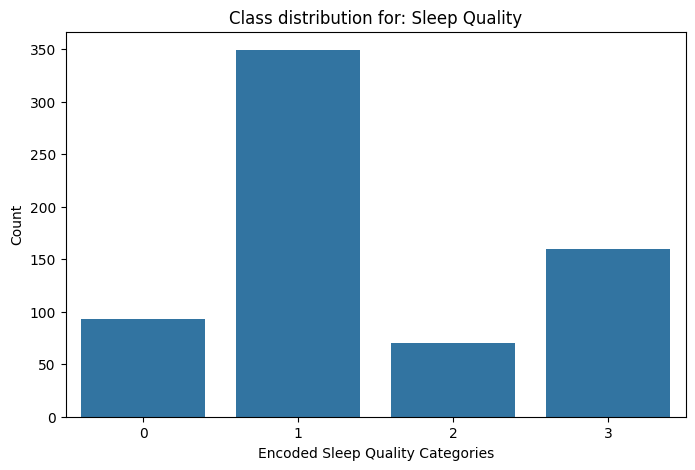

19. during the past month, how would you rate your sleep quality overall?
1    0.519345
3    0.238095
0    0.138393
2    0.104167
Name: proportion, dtype: float64


In [6]:
plt.figure(figsize=(8, 5))
sns.countplot(x=target, data=df)
plt.title(f'Class distribution for: Sleep Quality')
plt.xlabel('Encoded Sleep Quality Categories')
plt.ylabel('Count')
plt.show()

print(df[target].value_counts(normalize=True).rename('proportion'))

#Quick EDA: correlations

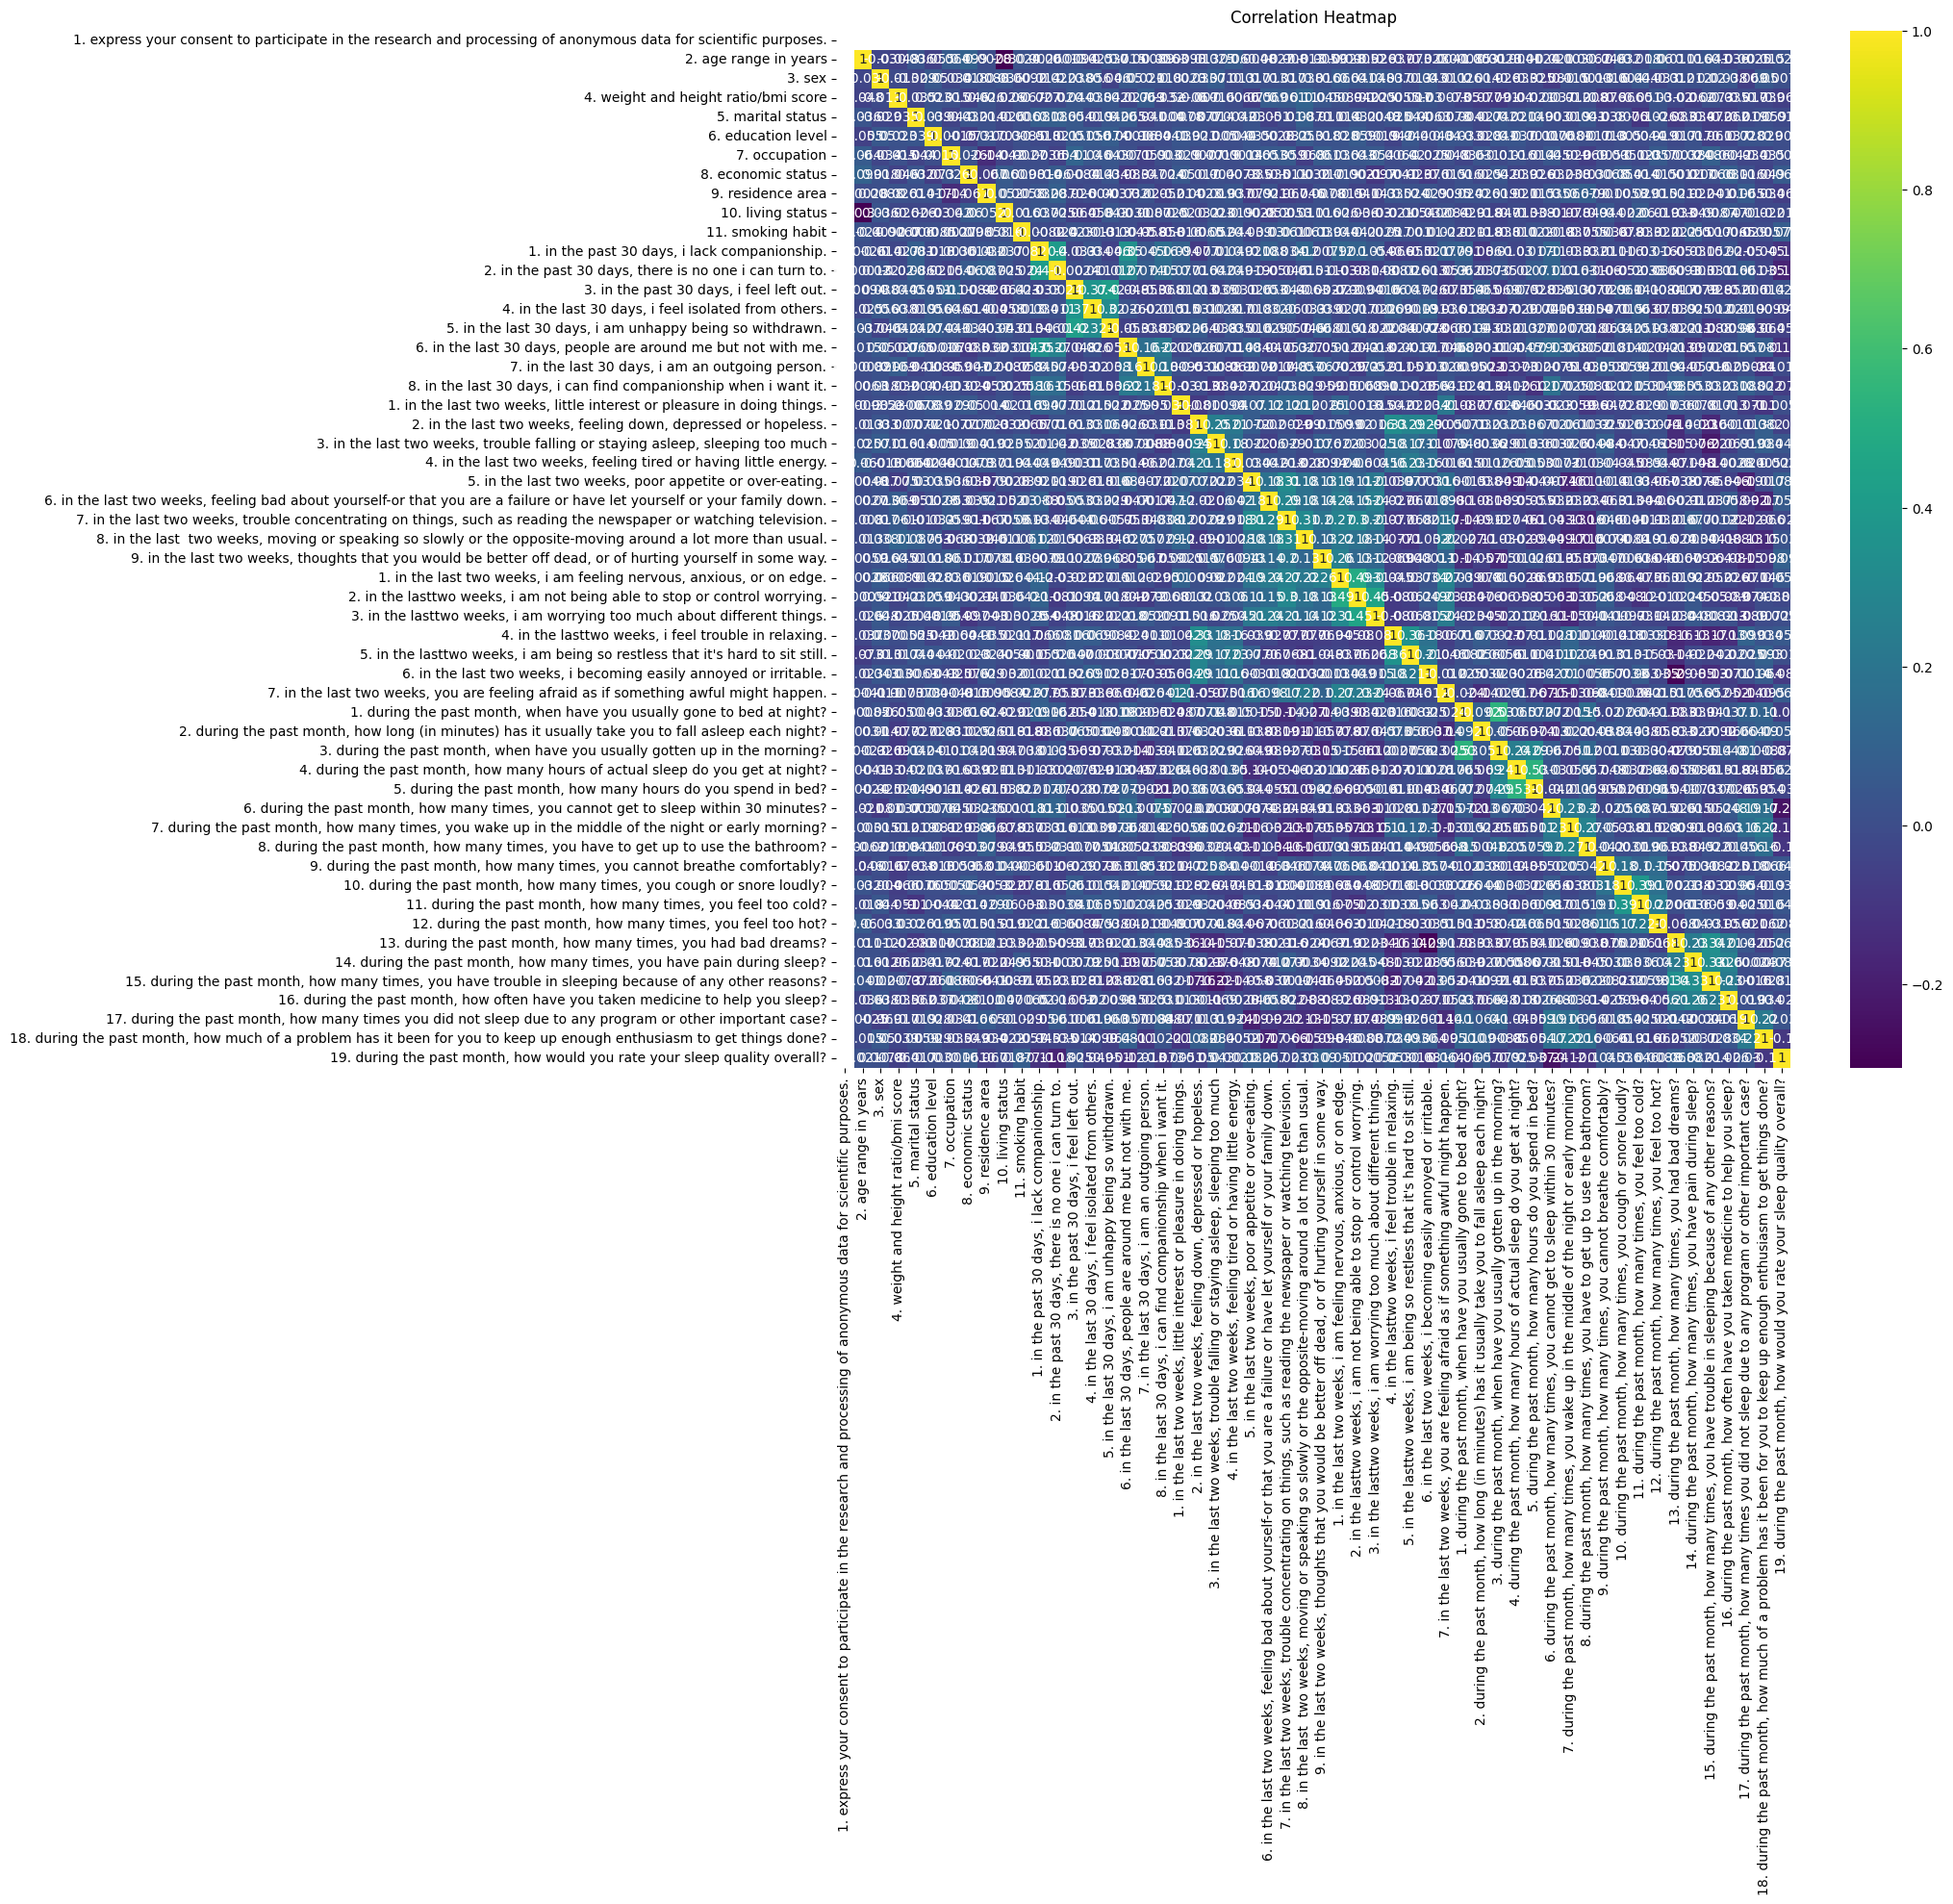

In [8]:
plt.figure(figsize=(16, 14))
sns.heatmap(df.corr(numeric_only=True), cmap='viridis', annot=True)
plt.title('Correlation Heatmap')
plt.show()

#t-SNE visualization

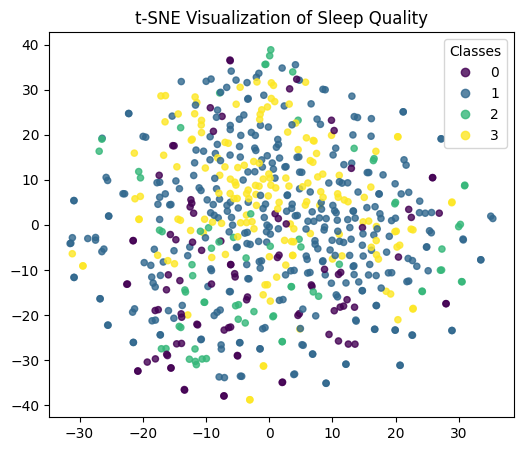

In [10]:
from sklearn.manifold import TSNE

# Ensure target column exists before dropping
if target in df.columns:
    X_vis = df.drop(columns=[target])
    y_vis = df[target]

    X_vis_scaled = StandardScaler().fit_transform(X_vis)

    tsne = TSNE(n_components=2, random_state=42, init='random', learning_rate='auto', perplexity=min(30, len(df)-1))
    X2 = tsne.fit_transform(X_vis_scaled)

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(X2[:, 0], X2[:, 1], c=y_vis, s=20, alpha=0.8, cmap='viridis')
    plt.title('t-SNE Visualization of Sleep Quality')
    plt.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(y_vis)), title="Classes")
    plt.show()

#Define X / y

In [11]:
X = df.drop(columns=[target])
y = df[target].astype(int)

print("X shape:", X.shape, "| y values:", y.unique())

X shape: (672, 53) | y values: [0 1 3 2]


# Cross-validation plan

In [12]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scoring = {'accuracy': make_scorer(accuracy_score)}

#Scalers & classifiers

In [13]:
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM (RBF)": SVC(kernel='rbf', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
}

#Feature engineering blocks

In [14]:
def pca_block():
    return ('pca', PCA(n_components=0.95, random_state=42))

def lda_block():
    return ('lda', LDA(solver='svd'))

def rfe_block():
    base = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    return ('rfe', RFE(estimator=base, n_features_to_select=10, step=1)) # Increased features to 10

def boruta_block():
    base = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1, class_weight='balanced')
    # Using a class that wraps BorutaPy for sklearn pipeline compatibility
    class BorutaWrapper(BorutaPy):
        def transform(self, X, y=None):
            return super().transform(X)
        def fit_transform(self, X, y=None):
            return super().fit(X, y).transform(X)

    return ('boruta', BorutaWrapper(estimator=base, n_estimators='auto', verbose=0, random_state=42, max_iter=50))

#Define all feature methods

In [15]:
feature_methods = {
    "All Features": [],
    "PCA": [pca_block()],
    "LDA": [lda_block()],
    "RFE": [rfe_block()],
    "Boruta": [boruta_block()]
}

#Run experiment

In [17]:
results = []

for scaler_name, scaler in scalers.items():
    for method_name, method_steps in feature_methods.items():
        for clf_name, clf in classifiers.items():

            steps = [('scaler', scaler)]

            # SMOTE and LDA can't be used together
            if method_name != 'LDA':
                steps.append(('smote', SMOTE(random_state=42)))

            steps.extend(method_steps)
            steps.append(('clf', clf))

            pipe = Pipeline(steps)

            try:
                cv_out = cross_validate(
                    pipe, X.values, y.values,  # Using .values to avoid column name issues
                    cv=cv,
                    scoring=scoring,
                    return_train_score=False,
                    n_jobs=-1
                )

                fold_scores = cv_out['test_accuracy']

                results.append({
                    'Scaler': scaler_name,
                    'Method': method_name,
                    'Classifier': clf_name,
                    'Fold_Scores': fold_scores,
                    'Mean_Accuracy': float(np.mean(fold_scores)),
                    'Std_Accuracy': float(np.std(fold_scores, ddof=1))
                })
                print(f"Finished: {scaler_name} | {method_name} | {clf_name}")

            except Exception as e:
                print(f"FAILED: {scaler_name} | {method_name} | {clf_name} with error: {e}")


results_df = pd.DataFrame(results).sort_values('Mean_Accuracy', ascending=False).reset_index(drop=True)

print("\n✅ Done evaluating all combinations.")
results_df[['Scaler','Method','Classifier','Mean_Accuracy','Std_Accuracy']].head(10)

Finished: StandardScaler | All Features | Logistic Regression
Finished: StandardScaler | All Features | KNN
Finished: StandardScaler | All Features | SVM (RBF)
Finished: StandardScaler | All Features | Random Forest
Finished: StandardScaler | PCA | Logistic Regression
Finished: StandardScaler | PCA | KNN
Finished: StandardScaler | PCA | SVM (RBF)
Finished: StandardScaler | PCA | Random Forest
Finished: StandardScaler | LDA | Logistic Regression
Finished: StandardScaler | LDA | KNN
Finished: StandardScaler | LDA | SVM (RBF)
Finished: StandardScaler | LDA | Random Forest
Finished: StandardScaler | RFE | Logistic Regression
Finished: StandardScaler | RFE | KNN
Finished: StandardScaler | RFE | SVM (RBF)
Finished: StandardScaler | RFE | Random Forest
Finished: StandardScaler | Boruta | Logistic Regression
Finished: StandardScaler | Boruta | KNN
Finished: StandardScaler | Boruta | SVM (RBF)
Finished: StandardScaler | Boruta | Random Forest
Finished: MinMaxScaler | All Features | Logistic Reg

,Scaler,Method,Classifier,Mean_Accuracy,Std_Accuracy
0,MinMaxScaler,RFE,Random Forest,0.897778,0.032880
1,StandardScaler,RFE,Random Forest,0.896289,0.031918
2,RobustScaler,RFE,Random Forest,0.894830,0.027155
3,MinMaxScaler,Boruta,Random Forest,0.819926,0.025177
4,StandardScaler,Boruta,Random Forest,0.815931,0.032890
5,RobustScaler,Boruta,Random Forest,0.810993,0.024164
6,MinMaxScaler,All Features,Random Forest,0.810477,0.027237
7,StandardScaler,All Features,Random Forest,0.804533,0.031500
8,RobustScaler,All Features,Random Forest,0.800055,0.031129
9,StandardScaler,RFE,SVM (RBF),0.674553,0.038130


#Pretty results table

In [18]:
disp = results_df.copy()
disp['Accuracy (mean ± std)'] = (disp['Mean_Accuracy']*100).round(2).astype(str) + \
                                 '% ± ' + (disp['Std_Accuracy']*100).round(2).astype(str) + '%'

cols = ['Scaler', 'Method', 'Classifier', 'Accuracy (mean ± std)', 'Mean_Accuracy']
disp_table = disp[cols].sort_values(by='Mean_Accuracy', ascending=False).drop(columns=['Mean_Accuracy'])

print("--- 🏆 Final Accuracy (mean ± std) ---")
print(disp_table.to_string(index=False))

--- 🏆 Final Accuracy (mean ± std) ---
        Scaler       Method          Classifier Accuracy (mean ± std)
  MinMaxScaler          RFE       Random Forest        89.78% ± 3.29%
StandardScaler          RFE       Random Forest        89.63% ± 3.19%
  RobustScaler          RFE       Random Forest        89.48% ± 2.72%
  MinMaxScaler       Boruta       Random Forest        81.99% ± 2.52%
StandardScaler       Boruta       Random Forest        81.59% ± 3.29%
  RobustScaler       Boruta       Random Forest         81.1% ± 2.42%
  MinMaxScaler All Features       Random Forest        81.05% ± 2.72%
StandardScaler All Features       Random Forest        80.45% ± 3.15%
  RobustScaler All Features       Random Forest        80.01% ± 3.11%
StandardScaler          RFE           SVM (RBF)        67.46% ± 3.81%
  MinMaxScaler          RFE           SVM (RBF)        65.48% ± 3.83%
  RobustScaler          RFE           SVM (RBF)         61.7% ± 4.39%
StandardScaler       Boruta           SVM (RBF)     

#Plot top N combos

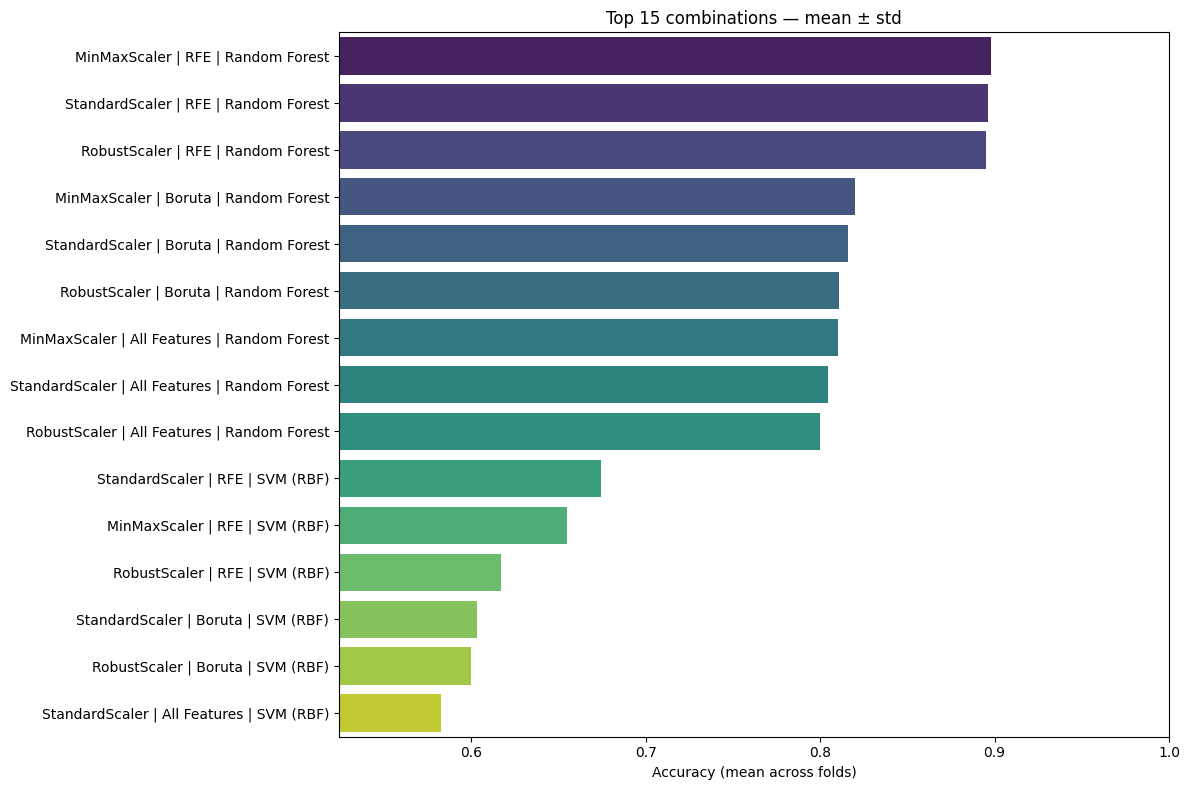

In [20]:
top_n = 15
plot_df = results_df.head(top_n).copy()
plot_df['label'] = plot_df['Scaler'] + ' | ' + plot_df['Method'] + ' | ' + plot_df['Classifier']

plt.figure(figsize=(12, 8))
sns.barplot(
    data=plot_df,
    y='label', x='Mean_Accuracy',
    palette='viridis'
)
plt.xlim(left=plot_df['Mean_Accuracy'].min() * 0.9, right=1.0) # Adjust x-axis for better view
plt.xlabel('Accuracy (mean across folds)')
plt.ylabel('')
plt.title(f'Top {top_n} combinations — mean ± std')
plt.tight_layout()
plt.show()